### Packages

In [16]:
import wrds
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from numba import njit
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

### Downloading and extracting the needed data, and computing the spread

Now I will connect to WRDS, loop through each year, query stock data, pivot it to get daily returns, calculate monthly returns and spreads, and store them.

To download the data to run this code, uncomment the cell under and comment the cell after.

In [17]:
# # Connect to WRDS
# db = wrds.Connection()

# # Define years to process
# start_year, end_year = 1926, 2025
# years = range(start_year, end_year+1, 1)

# # Place to store monthly data
# monthly_returns = pd.DataFrame()
# monthly_spread = pd.DataFrame()

# # Process each year
# for year in years:
#     query = f"""
#     SELECT a.permno, b.ticker, a.date, a.ret
#     FROM crsp.dsf AS a
#     JOIN crsp.stksecurityinfohist AS c
#     ON a.permno = c.permno AND a.date BETWEEN c.secinfostartdt AND c.secinfoenddt
#     JOIN crsp.stocknames AS b
#     ON a.permno = b.permno AND a.date BETWEEN b.namedt AND b.nameenddt
#     WHERE a.date >= '{year}-01-01' AND a.date <= '{year}-12-31'
#     AND a.ret IS NOT NULL
#     AND c.primaryexch IN ('N', 'A', 'Q')
#     AND c.sharetype = 'NS'
#     AND c.securitytype = 'EQTY'
#     AND c.securitysubtype = 'COM'
#     AND c.issuertype IN ('ACOR', 'CORP')
#     """
#     # Load data in chunks to avoid memory issues
#     data = db.raw_sql(query, date_cols=['date'])

#     # Turning it into a pivot table
#     data = data.pivot(
#         index='date',
#         columns='permno',
#         values='ret'
#     )

#     # Getting monthly returns
#     monthly_returns = pd.concat([
#         monthly_returns, 
#         data.resample('M').apply(lambda x: (1 + x).prod() - 1)
#         ], axis=0, join='outer')

#     # Turning the monthly spread
#     # resample is the same as groupby in this case
#     monthly_spread = pd.concat([
#         monthly_spread, 
#         data.resample('M').apply(lambda x: 2*np.sqrt(abs(x.cov(x.shift(1)))))
#         ], axis=0, join='outer')
    
#     print(f"Processed data for {year}")
#     del data

# # Close WRDS connection
# db.close()

# print(f"We have {len(monthly_returns.columns)} stocks in our universe")

In [18]:
start_year, end_year = 1926, 2025
monthly_returns = pd.read_csv('monthly_returns.csv', index_col=0, parse_dates=True)
monthly_spread = pd.read_csv('monthly_spread.csv', index_col=0, parse_dates=True)
print(f"We have {len(monthly_returns.columns)} stocks in our universe")

We have 29362 stocks in our universe


### Computing portfolios based on the spread

Now I will rank monthly spreads, shift ranks by one month to avoid look-ahead bias, split ranks into quintiles, and calculate average returns for each quintile.

In [19]:
# Ranking the spreads and shifting by one month to avoid look-ahead bias
ranks = monthly_spread.rank(axis=1, method='first').shift(1)

# Splitting the ranks into quintiles
quintiles = ranks.dropna(how='all', axis=0).apply(lambda x: pd.qcut(x, 5, labels=False), axis=1)

# Getting the quintile returns
quintile_returns = pd.DataFrame(index=monthly_returns.index, columns=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
for i in range(5):
    # Getting the returns for each quintile
    quintile_returns.iloc[:, i] = monthly_returns.where(quintiles == i).mean(axis=1)

### Computing portfolios after the spread is taken into account

Now I will adjust monthly returns by subtracting half the spread and calculate average returns for each quintile based on the adjusted returns.

In [20]:
# Getting the excess spread returns
quintile_spreads = pd.DataFrame(index=monthly_returns.index, columns=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
weights = {}
for i in range(5):
    # Getting the stocks in the quintile
    weights[f"Q{i+1}"] = pd.DataFrame(np.where(quintiles == i, 1, 0),
                         index=quintiles.index,
                         columns=quintiles.columns)
    
    # Getting the equally weighted weights
    weights[f"Q{i+1}"] = weights[f"Q{i+1}"].apply(lambda x: x / x.sum(), axis=1)
    if i == 4:
        weights['Q5 - Q1'] = pd.DataFrame(np.where(weights['Q5'] == 0, -weights['Q1'], weights['Q5']),
                                    index=quintiles.index,
                                    columns=quintiles.columns)

    # Getting the rolling weight of the portfolio (how much we buy/sell of a stock)
    # We fill the first row in the shift with 0 as our portfolio starts with 0 inventory
    weights[f"Q{i+1} rolling"] = weights[f"Q{i+1}"] - weights[f"Q{i+1}"].shift(1, fill_value=0)
    if i == 4:
        weights['Q5 - Q1 rolling'] = weights['Q5 - Q1'] - weights['Q5 - Q1'].shift(1, fill_value=0)

    # Getting the quintile portfolios spread
    # abs here since we don't care if we buy or sell (+ / -), paying TC is inevitable
    # / 2 since we pay only half of the spread when we buy and half when we sell
    weights[f"Q{i+1} spread"] = abs(weights[f"Q{i+1} rolling"]) * (monthly_spread.iloc[1:] / 2) * (abs(monthly_returns).iloc[1:])
    if i == 4:
        weights['Q5 - Q1 spread'] = abs(weights['Q5 - Q1 rolling']) * (monthly_spread.iloc[1:] / 2) * (abs(monthly_returns).iloc[1:])

    # Getting the quintile spread
    quintile_spreads[f"Q{i+1}"] = weights[f"Q{i+1} spread"].sum(axis=1)
    if i == 4:
        quintile_spreads['Q5 - Q1'] = weights['Q5 - Q1 spread'].sum(axis=1)

    
# Getting the excess returns
quintile_returns['Q5 - Q1'] = quintile_returns['Q5'] - quintile_returns['Q1']
quintile_returns_after_spreads = quintile_returns - quintile_spreads

# Making sure all the data is numeric
quintile_returns = quintile_returns.apply(pd.to_numeric, errors='coerce')
quintile_spreads = quintile_spreads.apply(pd.to_numeric, errors='coerce')
quintile_returns_after_spreads = quintile_returns_after_spreads.apply(pd.to_numeric, errors='coerce')

In [21]:
quintile_returns.mean()*12

Q1         0.136676
Q2         0.143731
Q3         0.148337
Q4         0.151633
Q5         0.139457
Q5 - Q1    0.002781
dtype: float64

In [22]:
quintile_returns_after_spreads.mean()*12

Q1         0.118300
Q2         0.121336
Q3         0.118883
Q4         0.110946
Q5         0.097104
Q5 - Q1   -0.057949
dtype: float64

In [23]:
quintile_returns.mean()*12 - quintile_returns_after_spreads.mean()*12

Q1         0.018376
Q2         0.022395
Q3         0.029454
Q4         0.040687
Q5         0.042353
Q5 - Q1    0.060729
dtype: float64

### Analysis of the portfolios

This code defines a function to perform stationary bootstrap resampling on a 2-column array of return series, using an average block length and specified sample length, returning a resampled array.

In [24]:
@njit
def stationary_bootstrap(data: np.ndarray, m: float, sample_length: int) -> np.ndarray:
    """
    This function performs stationary bootstrap resampling on an Nx2 array of return series.

    Parameters:
    data (np.ndarray): The input data array with shape (N, 2), where N is the number of time points
                       and each column is a return series.
    m (float): The average block length.
    sample_length (int): The length of the resampled output.

    Returns:
    np.ndarray: The resampled data array with shape (sample_length, 2).
    """

    # Calculate the acceptance probability
    accept = 1 / m
    data_length = data.shape[0]

    # Initialize the starting index for the sample
    sample_index = np.random.randint(0, data_length)
    sample = np.zeros((sample_length, 2))

    # Loop through each sample point
    for i_sample in range(sample_length):
        # Decide whether to continue the current block or start a new one
        if np.random.uniform(0, 1) >= accept:
            sample_index += 1
            # Wrap around if the index exceeds the data length
            if sample_index >= data_length:
                sample_index = 0
        else:
            # Start a new block with a random index
            sample_index = np.random.randint(0, data_length)

        # Assign the selected row (both series) to the sample
        sample[i_sample, :] = data[sample_index, :]

    return sample

The function performs bootstrap resampling to compute p-values for the proportion of times the mean, standard deviation, and Sharpe ratio of the first column are greater than those of the second column.

In [25]:
def bootstrap_sign(returns, m=5, sample_length=1, n_boot=100000):
    """
    Perform bootstrap resampling to calculate the proportion of times 
    the mean of the first column is less than the mean of the second column.

    Parameters:
    - returns (pd.DataFrame or np.ndarray): Input data with two columns of returns.
    - m (float): Average block length for the stationary bootstrap.
    - sample_length (int): Length of the resampled output. Defaults to the length of `returns`.
    - n_boot (int): Number of bootstrap iterations.

    Returns:
    - float: Proportion of times the mean of the first column is less than the mean of the second column.
    """
    # If sample_length is not provided, use the length of the returns
    if sample_length == 1:
        sample_length = len(returns)

    # Getting the observation diff
    boot_diff = []

    # Perform bootstrap resampling n_boot times
    for i in range(n_boot):
        # Generate a bootstrap sample using the stationary bootstrap
        boot = stationary_bootstrap(np.array(returns).astype(float), m, sample_length)

        # Calculate the difference in means between the two columns
        boot_diff.append(boot[:, 0].mean() - boot[:, 1].mean())


    # Place to store the p-value
    p_values = np.sum(np.array(boot_diff) > 0) / len(boot_diff)
    return p_values

The function summarizes returns and adjusted returns for each quintile, calculating annualized mean, standard deviation, Sharpe ratio, skew, kurtosis, and tests weather the spread signficiantly predicts expected returns, storing results in a DataFrame.

In [26]:
def summerize_returns(returns, returns_after_spread):
    """
    Function to summerize the returns
    """
    df = pd.DataFrame(index=[['Mean', 'Std', 'Sharpe', 'Skew', 'Kurtosis', 'Max', 'Min', 
                              r'$p$-value ($\mu_{Q5} > \mu_{Q1}$)']],
                      columns=['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q5 - Q1', 
                               'Q1 (after spread)', 'Q2 (after spread)', 'Q3 (after spread)', 'Q4 (after spread)', 'Q5 (after spread)', 'Q5 - Q1 (after spread)'])
    for i in returns.columns:
        j = f"{i} (after spread)"
        df[i]['Mean'] = returns[i].mean() * 12
        df[j]['Mean'] = returns_after_spread[i].mean() * 12
        df[i]['Std'] = returns[i].std() * np.sqrt(12)
        df[j]['Std'] = returns_after_spread[i].std() * np.sqrt(12)
        df[i]['Sharpe'] = df[i]['Mean'] / df[i]['Std']
        df[j]['Sharpe'] = df[f"{i} (after spread)"]['Mean'] / df[f"{i} (after spread)"]['Std']
        df[i]['Skew'] = returns[i].skew()
        df[j]['Skew'] = returns_after_spread[i].skew()
        df[i]['Kurtosis'] = returns[i].kurtosis()
        df[j]['Kurtosis'] = returns_after_spread[i].kurtosis()
        df[i]['Max'] = returns[i].max()
        df[j]['Max'] = returns_after_spread[i].max()
        df[i]['Min'] = returns[i].min()
        df[j]['Min'] = returns_after_spread[i].min()

        if i == 'Q5 - Q1':
            df[i][r'$p$-value ($\mu_{Q5} > \mu_{Q1}$)'] = bootstrap_sign(returns[['Q1', 'Q5']], m=5, sample_length=1, n_boot=100000)
            df[j][r'$p$-value ($\mu_{Q5} > \mu_{Q1}$)'] = bootstrap_sign(returns_after_spread[['Q1', 'Q5']], m=5, sample_length=1, n_boot=100000)
    return df

The code initializes dictionaries to store summaries and significance results, defines multiple time periods (full, 10, 20, 25, 50 years), and for each period: extracts quintile returns, summarizes statistics, saves them as LaTeX tables, computes significance with t-tests and bootstrap tests, saves significance tables, plots cumulative returns for all quintiles and Q1/Q5 separately, plots average spreads, and saves all figures.

In [27]:
# Place to store the summary
summary = {}

# Periods we want to look at
## Full period
periods = [(start_year, end_year)]
## 10 year periods
periods += [(start, start + 9) for start in range(start_year, end_year+1, 10)]
## 20 year periods
periods += [(start, start + 19) for start in range(start_year, end_year+1, 20)]
## 25 year periods
periods += [(start, start + 24) for start in range(start_year, end_year+1, 25)]
## 50 year periods
periods += [(start, start + 49) for start in range(start_year, end_year+1, 50)]

# Loop through the periods
for start, end in periods:
    # Getting the data for the period
    period_data = quintile_returns.loc[str(start):str(end)]
    period_data_after_spread = quintile_returns_after_spreads.loc[str(start):str(end)]
    
    # Getting the summary for the period
    summary[f'{start}-{end}'] = summerize_returns(period_data, period_data_after_spread)

    # Storing the summary to a latex table
    summary[f'{start}-{end}'].to_latex(f'figures-and-tables/table-{end-start+1}y_summary_{start}_{end}.tex', 
                                       float_format='%.3f',
                                       escape=False,
                                       label=f'tab:summary_{start}_{end}',
                                       caption=f'Summary statistics for the period {start}-{end}')

    # Print the processed data
    print(f"Processed data for {start}-{end} ({end-start+1} years)")

Processed data for 1926-2025 (100 years)
Processed data for 1926-1935 (10 years)
Processed data for 1936-1945 (10 years)
Processed data for 1946-1955 (10 years)
Processed data for 1956-1965 (10 years)
Processed data for 1966-1975 (10 years)
Processed data for 1976-1985 (10 years)
Processed data for 1986-1995 (10 years)
Processed data for 1996-2005 (10 years)
Processed data for 2006-2015 (10 years)
Processed data for 2016-2025 (10 years)
Processed data for 1926-1945 (20 years)
Processed data for 1946-1965 (20 years)
Processed data for 1966-1985 (20 years)
Processed data for 1986-2005 (20 years)
Processed data for 2006-2025 (20 years)
Processed data for 1926-1950 (25 years)
Processed data for 1951-1975 (25 years)
Processed data for 1976-2000 (25 years)
Processed data for 2001-2025 (25 years)
Processed data for 1926-1975 (50 years)
Processed data for 1976-2025 (50 years)


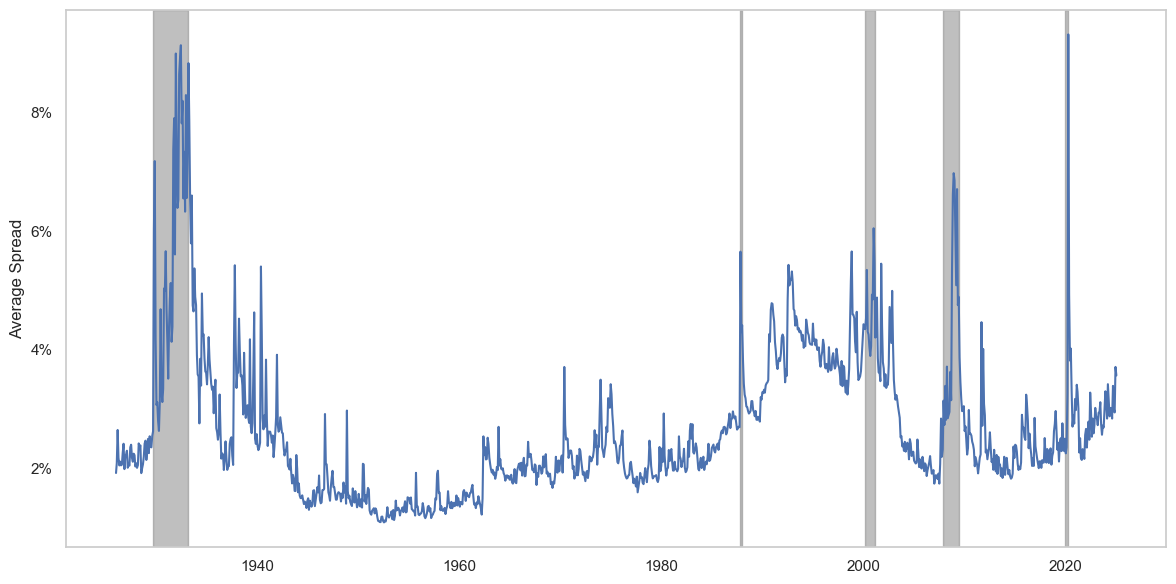

In [28]:
# Ploting the average spread over time
plt.figure(figsize=(12, 6))
plt.plot(monthly_spread.mean(axis=1), label='Average Spread')
plt.ylabel('Average Spread')
plt.grid()
plt.tight_layout()

# Marking crises between 1925-2024
crises = {
    '1929': ['1929-10-01', '1933-03-01'],
    '1987': ['1987-10-01', '1988-01-01'],
    '2000': ['2000-03-01', '2001-03-01'],
    '2008': ['2007-11-01', '2009-06-01'],
    '2020': ['2019-12-01', '2020-04-01']
}
for crisis, dates in crises.items():
    plt.axvspan(pd.to_datetime(dates[0]), pd.to_datetime(dates[1]), color='grey', alpha=0.5, label=f'{crisis} Crisis')

    # showing the y axis in %%
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
plt.savefig('figures-and-tables/average_spread_over_time.png', dpi=300)
plt.show()

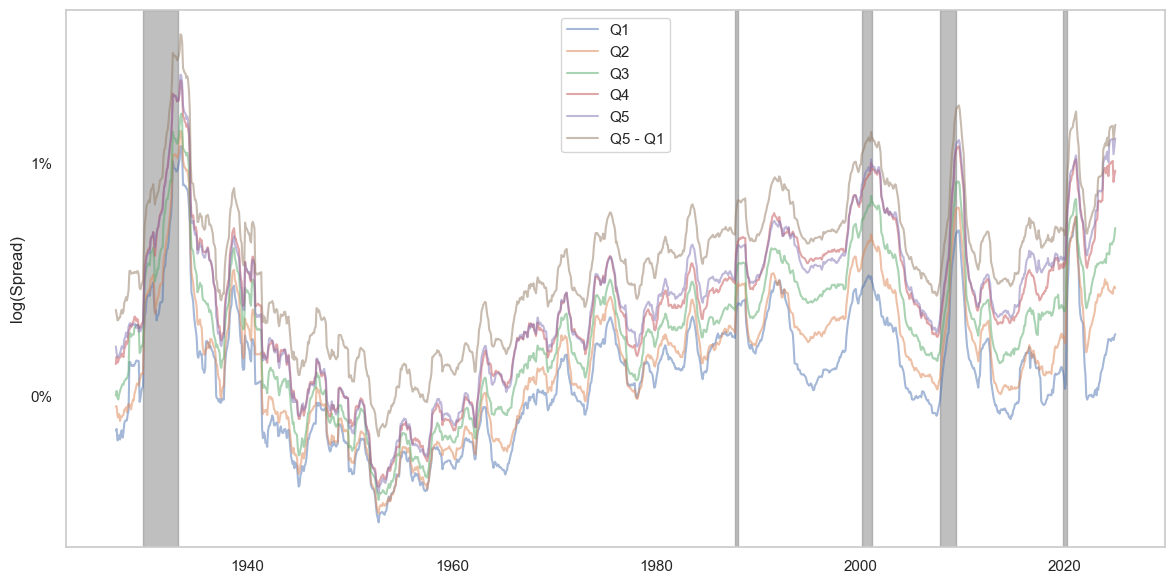

In [29]:
# Ploting the average spread over time for each quintile
plt.figure(figsize=(12, 6))
plt.plot(quintile_spreads.rolling(12).mean(), alpha=0.5)
plt.ylabel('log(Spread)')
plt.yscale('log')
plt.legend(quintile_spreads.columns)
plt.grid()
plt.tight_layout()

# Marking crises between 1925-2024
crises = {
    '1929': ['1929-10-01', '1933-03-01'],
    '1987': ['1987-10-01', '1988-01-01'],
    '2000': ['2000-03-01', '2001-03-01'],
    '2008': ['2007-11-01', '2009-06-01'],
    '2020': ['2019-12-01', '2020-04-01']
}
for crisis, dates in crises.items():
    plt.axvspan(pd.to_datetime(dates[0]), pd.to_datetime(dates[1]), color='grey', alpha=0.5, label=f'{crisis} Crisis')

    # showing the y axis in %%
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))

plt.savefig('figures-and-tables/average_spread_for_ptf_over_time.png', dpi=300)
plt.show()

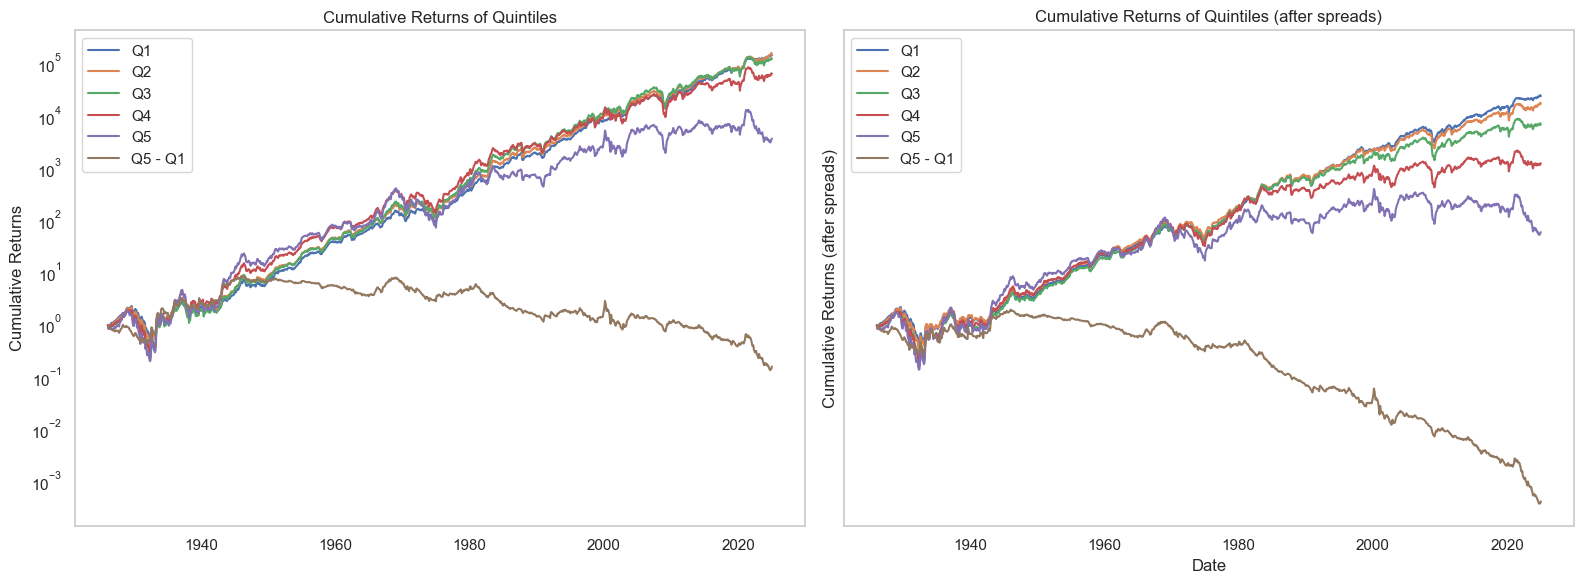

In [30]:
# Plotting cumulative returns of the quintiles with and without spreads in two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), sharey=True)
# Plotting the first subplot
axes[0].plot((1 + quintile_returns).cumprod())
axes[0].set_title('Cumulative Returns of Quintiles')
axes[0].set_ylabel('Cumulative Returns')
axes[0].set_yscale('log')
axes[0].grid()
axes[0].legend(quintile_returns.columns)
# Plotting the second subplot
axes[1].plot((1 + quintile_returns_after_spreads).cumprod())
axes[1].set_title('Cumulative Returns of Quintiles (after spreads)')
axes[1].set_ylabel('Cumulative Returns (after spreads)')
axes[1].set_yscale('log')
axes[1].set_xlabel('Date')
axes[1].grid()
axes[1].legend(quintile_returns_after_spreads.columns)
plt.tight_layout()
plt.savefig('figures-and-tables/cumulative_returns_quintiles.png', dpi=300)
plt.show()